In [18]:
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn.functional as F

from dhg import Hypergraph
from dhg.data import Cooking200, CocitationCora, CoauthorshipCora, CocitationPubmed, CoauthorshipDBLP, CocitationCiteseer, News20, Yelp3k, Tencent2k
from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator

from utils import *
from models import *
import pandas as pd

import matplotlib.pyplot as plt

In [19]:
dataset_names = ['CocitationCora', 'CocitationCiteseer', 'CoauthorshipCora', 'CoauthorshipDBLP', 'CocitationPubmed', 'Cooking200', 'Tencent2k']


for dataset in dataset_names:
    data = load_dataset(dataset)
    print(dataset)
    print(f"Number of classes : {data['num_classes']}")
    print(f"Number of nodes : {data['num_vertices']}")
    try:
        print(f"Feature size : {len(data['features'])}")    
    except AssertionError as e:
        print(f"No features for dataset: {dataset}")
    print(f"Number of edges : {data['num_edges']}")
    print('\n')

CocitationCora
Number of classes : 7
Number of nodes : 2708
Feature size : 2708
Number of edges : 1579


CocitationCiteseer
Number of classes : 6
Number of nodes : 3312
Feature size : 3312
Number of edges : 1079


CoauthorshipCora
Number of classes : 7
Number of nodes : 2708
Feature size : 2708
Number of edges : 1072


CoauthorshipDBLP
Number of classes : 6
Number of nodes : 41302
Feature size : 41302
Number of edges : 22363


CocitationPubmed
Number of classes : 3
Number of nodes : 19717
Feature size : 19717
Number of edges : 7963


Cooking200
Number of classes : 20
Number of nodes : 7403
No features for dataset: Cooking200
Number of edges : 2755


Tencent2k
Number of classes : 2
Number of nodes : 2146
Feature size : 2146
Number of edges : 6378




In [72]:
"""drop_rates = [0.05, 0.1, 0.2, 0.5, 0.8]
drop_methods = ['no dropout', 'dropnode', 'dropedge', 'drophyperedge']
depths = [1, 2, 4, 8, 12]
epochs = 500"""
drop_rates = [0.05, 0.1, 0.2, 0.5, 0.8]
drop_rate = 0.0
drop_methods = ['no dropout', 'dropnode', 'dropedge', 'drophyperedge']
depths = [1, 2, 4, 8, 12]
epochs = 500

selected_params = [{
    'depth' : depth,
    'drop_method': drop_method,
    'drop_rate' : drop_rate
} for drop_rate in drop_rates
for drop_method in drop_methods
for depth in depths]

print(len(selected_params))

4


In [73]:
set_seed(0)

model_names = ['HGNNP', 'UniSAGE', 'UniGCN', 'UniGIN', 'UniGAT', 'HNHN']
model_names = ['UniSAGE']
dataset_names = ['CocitationCora', 'CocitationCiteseer', 'CoauthorshipCora', 'CoauthorshipDBLP', 'CocitationPubmed', 'Cooking200', 'Tencent2k']
dataset_names = ['CoauthorshipCora']

df_results = pd.DataFrame()

for dataset in dataset_names:
    data = load_dataset(dataset)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    evaluator = Evaluator(["accuracy"])
    # Add code to check for features before using the adjacency matrix
    try:
        X, lbl = data["features"], data["labels"]  
    except AssertionError as e:
        X, lbl = torch.eye(data["num_vertices"]), data["labels"]
    ids = list(range(data['num_vertices']))
    relations = data["edge_list"]
       
    train_mask = data["train_mask"]
    val_mask = data["val_mask"]
    test_mask = data["test_mask"]

    for model in model_names:
        for params in selected_params:
            depth = params['depth']
            drop_method = params['drop_method']
            init_drop_rate = params['drop_rate']
            oversmoothing = []
            loss_values = []
            val_accuracy = []
            

            net = load_model(model, X, data, depth)
            optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4)
            X, lbl = X.to(device), lbl.to(device)
            G = Hypergraph(data["num_vertices"], data["edge_list"])
            G = G.to(device)
            net = net.to(device)

            best_state = None
            best_epoch, best_val = 0, 0

            for epoch in range(epochs): 
                
                set_seed(epoch)                   
                #drop_rate = torch.tanh(energy) * init_drop_rate
                
                # train
                G = dropout_hgnn(drop_method, drop_rate, ids, relations)
                loss_item = train(net, X, G, lbl, train_mask, optimizer, epoch)

                # validation
                if epoch % 10 == 0:
                    with torch.no_grad():
                        val_res, energy = infer(net, X, G, lbl, val_mask, evaluator)
                        drop_rate = torch.exp(-3 * energy) * init_drop_rate
                        print(f"Oversmoothing measure : {energy}")
                        print(f"Old drop rate : {init_drop_rate} New drop rate : {drop_rate}")
                    if val_res > best_val:
                        print(f"update best: {val_res:.5f}")
                        best_epoch = epoch
                        best_val = val_res
                        best_state = deepcopy(net.state_dict())
                    val_accuracy.append(val_res)
                    oversmoothing.append(energy.item())
                    loss_values.append(loss_item)
                if epoch % 20 == 0:
                    
                    res, _ = infer(net, X, G, lbl, test_mask, evaluator, test=True)
                    results = {
                        'model' : model,
                        'data' : dataset,
                        'depth' : depth,
                        'epochs' : epoch,
                        'best_val_accuracy' : best_val,
                        'test_accuracy' : res['accuracy'],
                        'drop_method': drop_method,
                        'drop_rate' : init_drop_rate,
                        'oversmoothing' : oversmoothing,
                        'val_accuracy' : val_accuracy,
                        'loss' : loss_values
                    }
                    df_results = pd.concat([df_results, pd.DataFrame([results])], ignore_index = True)
                

            print("\ntrain finished")
            print(f"best val: {best_val:.5f}")
            # test
            print("test...")
            net.load_state_dict(best_state)        
            res, _ = infer(net, X, G, lbl, test_mask, evaluator, test=True)
            print(f"final result: epoch: {best_epoch}")
            print(f"parameters used: {params}")
            print(res)
            results = {
                'model' : model,
                'data' : dataset,
                'depth' : depth,
                'epochs' : epoch+1,
                'best_val_accuracy' : best_val,
                'test_accuracy' : res['accuracy'],
                'drop_method': drop_method,
                'drop_rate' : init_drop_rate,
                'oversmoothing' : oversmoothing,
                'val_accuracy' : val_accuracy,
                'loss' : loss_values
            }

            df_results = pd.concat([df_results, pd.DataFrame([results])], ignore_index = True)

Epoch: 0, Time: 0.46794s, Loss: 2.28001
Oversmoothing measure : 8.800609588623047
Old drop rate : 0.2 New drop rate : 6.836934989505605e-13
update best: 0.07983
Epoch: 1, Time: 0.41707s, Loss: 33.11888
Epoch: 2, Time: 0.40548s, Loss: 9.25906
Epoch: 3, Time: 0.38443s, Loss: 3.15378
Epoch: 4, Time: 0.41121s, Loss: 2.44893
Epoch: 5, Time: 0.44772s, Loss: 2.25502
Epoch: 6, Time: 0.51762s, Loss: 2.09087
Epoch: 7, Time: 0.42593s, Loss: 1.99410
Epoch: 8, Time: 0.39471s, Loss: 2.09844
Epoch: 9, Time: 0.43414s, Loss: 1.99057
Epoch: 10, Time: 0.42212s, Loss: 2.14829
Oversmoothing measure : 1.643692135810852
Old drop rate : 0.2 New drop rate : 0.001443745568394661
update best: 0.12188
Epoch: 11, Time: 0.51589s, Loss: 2.12894
Epoch: 12, Time: 0.41817s, Loss: 2.03310
Epoch: 13, Time: 0.39554s, Loss: 1.99842
Epoch: 14, Time: 0.40643s, Loss: 2.00061
Epoch: 15, Time: 0.39063s, Loss: 1.95165
Epoch: 16, Time: 0.38965s, Loss: 1.97718
Epoch: 17, Time: 0.46584s, Loss: 1.93053
Epoch: 18, Time: 0.40539s, Los

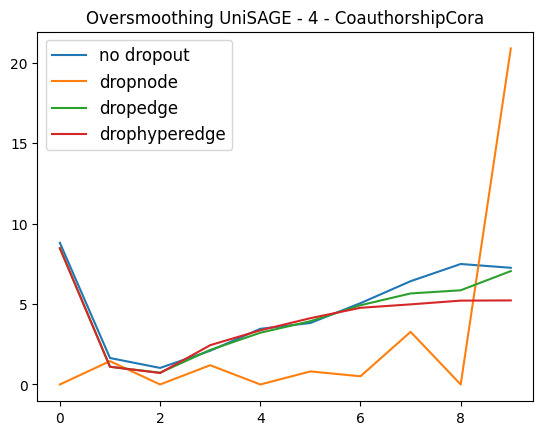

In [74]:
for dataset in dataset_names:
    for model in model_names:
        for depth in depths:
            oversmoothing_values = df_results[
                (df_results['epochs']== epochs) & (df_results['data']== dataset) & (df_results['model']== model) & (df_results['depth']== depth)
                ]
            for method in drop_methods:
                values = oversmoothing_values[oversmoothing_values['drop_method']== method]['oversmoothing'].values[0]
                plt.plot(values, label = method)
                plt.title(f"Oversmoothing {model} - {depth} - {dataset}")
            plt.legend(prop={'size': 12}, title_fontsize=12)
            plt.show()
        

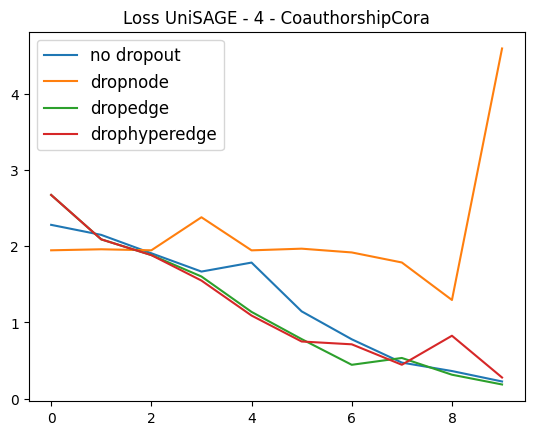

In [75]:
for dataset in dataset_names:
    for model in model_names:
        for depth in depths:
            loss_values = df_results[
                (df_results['epochs']== epochs) & (df_results['data']== dataset) & (df_results['model']== model) & (df_results['depth']== depth)
                ]
            for method in drop_methods:
                values = loss_values[loss_values['drop_method']== method]['loss'].values[0]
                plt.plot(values, label = method)
                plt.title(f"Loss {model} - {depth} - {dataset}")
            plt.legend(prop={'size': 12}, title_fontsize=12)
            plt.show()
        

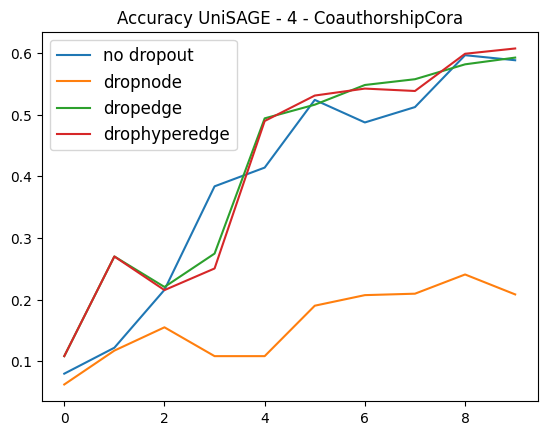

In [76]:
for dataset in dataset_names:
    for model in model_names:
        for depth in depths:
            accuracy_values = df_results[
                (df_results['epochs']== epochs) & (df_results['data']== dataset) & (df_results['model']== model) & (df_results['depth']== depth)
                ]
            for method in drop_methods:
                values = accuracy_values[accuracy_values['drop_method']== method]['val_accuracy'].values[0]
                
                plt.plot(values, label = method)
                plt.title(f"Accuracy {model} - {depth} - {dataset}")
            plt.legend(prop={'size': 12}, title_fontsize=12)
            plt.show()
        

In [77]:
df_results[df_results['epochs'] == epochs].head(20)

,model,data,depth,epochs,best_val_accuracy,test_accuracy,drop_method,drop_rate,oversmoothing,val_accuracy,loss
5,UniSAGE,CoauthorshipCora,4,100,0.596184,0.596184,no dropout,0.2,"[8.800609588623047, 1.643692135810852, 1.02906...","[0.0798286572098732, 0.12188473343849182, 0.21...","[2.280012369155884, 2.1482911109924316, 1.9069..."
11,UniSAGE,CoauthorshipCora,4,100,0.240654,0.240654,dropnode,0.2,"[0.0, 1.4489774703979492, 0.0, 1.1984728574752...","[0.06230529770255089, 0.11721184104681015, 0.1...","[1.9459372758865356, 1.9593002796173096, 1.945..."
17,UniSAGE,CoauthorshipCora,4,100,0.592290,0.592290,dropedge,0.2,"[8.46452808380127, 1.0997616052627563, 0.73377...","[0.10825545340776443, 0.26985982060432434, 0.2...","[2.672694206237793, 2.089641571044922, 1.88372..."
23,UniSAGE,CoauthorshipCora,4,100,0.607087,0.607087,drophyperedge,0.2,"[8.46452808380127, 1.0997616052627563, 0.71242...","[0.10825545340776443, 0.26985982060432434, 0.2...","[2.672694206237793, 2.089641571044922, 1.88273..."
